<a href="https://colab.research.google.com/github/anthonymalumbe/KaggleX_Titanic/blob/main/Leveraging_ML_for_Early_Detection_of_COVID_19_through_Chest_Imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import itertools

from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [ ]:
os.environ['KAGGLE_USERNAME'] = "anthonymalumbe"
os.environ['KAGGLE_KEY'] = "0cb4a0f3fe6d28695713571db2848621"

Download the COVID-19 Dataset

In [ ]:
path = "COVID-QU-Ex Dataset"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)

In [ ]:
# defining Path

checkfileexists = '/covidqu.zip'

# Checking whether the specified path exists
isFile = os.path.isfile(checkfileexists)
if not isFile:
  !kaggle datasets download anasmohammedtahir/covidqu

 99% 1.13G/1.15G [00:15<00:00, 98.6MB/s]
100% 1.15G/1.15G [00:15<00:00, 78.5MB/s]


Uzip the COVID-19 Dataset zip file

In [ ]:
!unzip -n -q covidqu.zip  -d "COVID-QU-Ex Dataset/"

List the number of images in the Lung Segementation Directories

In [ ]:
len(os.listdir('COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Test/COVID-19/images'))

2395

In [ ]:
len(os.listdir('COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Train/COVID-19/images'))

7658

In [ ]:
len(os.listdir('COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Val/COVID-19/images'))

1903

In [ ]:
len(os.listdir('COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Test/Normal/images'))

2140

In [ ]:
len(os.listdir('COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Train/Normal/images'))

6849

In [ ]:
len(os.listdir('COVID-QU-Ex Dataset/Lung Segmentation Data/Lung Segmentation Data/Val/Normal/images'))

1712

List the number of images in the Infection Segementation Directories

In [ ]:
len(os.listdir('COVID-QU-Ex Dataset/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/images'))

583

In [ ]:
len(os.listdir('COVID-QU-Ex Dataset/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/images'))

1864

In [ ]:
len(os.listdir('COVID-QU-Ex Dataset/Infection Segmentation Data/Infection Segmentation Data/Val/COVID-19/images'))

466

In [ ]:
len(os.listdir('COVID-QU-Ex Dataset/Infection Segmentation Data/Infection Segmentation Data/Test/Normal/images'))

291

In [ ]:
len(os.listdir('COVID-QU-Ex Dataset/Infection Segmentation Data/Infection Segmentation Data/Train/Normal/images'))

932

In [ ]:
len(os.listdir('COVID-QU-Ex Dataset/Infection Segmentation Data/Infection Segmentation Data/Val/Normal/images'))

233

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(
        tpu="local")
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU")
except tf.errors.NotFoundError:
    print("Not running on TPU")
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS:", strategy.num_replicas_in_sync)

Not running on TPU
REPLICAS: 1


Configuration

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

NUM_CLASS = 3
CLASSES = ['COVID-19', 'Non-COVID', 'Normal']

IMAGE_SIZE = [224, 224]
LR = 1e-5
EPOCHS = 1
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

TRAINING_PATH = 'COVID-QU-Ex Dataset/Infection Segmentation Data/Infection Segmentation Data/Train'
TESTING_PATH = 'COVID-QU-Ex Dataset/Infection Segmentation Data/Infection Segmentation Data/Test'
VALIDATION_PATH = 'COVID-QU-Ex Dataset/Infection Segmentation Data/Infection Segmentation Data/Val'

Utilities

In [ ]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    return numpy_images, np.argmax(numpy_labels, axis=1)

In [ ]:
def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct


In [ ]:
def display_one(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2),
                  color='red' if red else 'black', fontdict={'verticalalignment': 'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

In [ ]:
def display_batch(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)

    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows

    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot = (rows, cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE, FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols, FIGSIZE))

    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows, cols)*40+3
        # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one(image, title, subplot,
                              not correct, titlesize=dynamic_titlesize)

    # layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [ ]:
def display_history(history):
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    ax[0].plot(history.history['loss'], color='b', label="training_loss")
    ax[0].plot(history.history['val_loss'], color='r',
               label="validation_loss", axes=ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['accuracy'],
               color='b', label="training_accuracy")
    ax[1].plot(history.history['val_accuracy'],
               color='r', label="validation_accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()

In [ ]:
def display_confusion_matrix(
        cm, classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

DataSet

In [ ]:
def create_dataframe(data_dir):
    filenames, labels = [], []
    for fold in os.listdir(data_dir):
        path = os.path.join(data_dir, fold, 'images')
        filelist = [os.path.join(path, filename)
                    for filename in os.listdir(path)]
        filenames.extend(filelist)
        labels.extend([fold] * len(filelist))
    return pd.DataFrame({
        'filename': filenames,
        'label': labels
    })


train_df = create_dataframe(TRAINING_PATH)
val_df = create_dataframe(VALIDATION_PATH)
test_df = create_dataframe(TESTING_PATH)

In [ ]:
NUM_TRAINING_IMAGES = len(train_df.index)
NUM_VALIDATION_IMAGES = len(val_df)
NUM_TEST_IMAGES = len(test_df)

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = -(- NUM_VALIDATION_IMAGES // BATCH_SIZE)
TEST_STEPS = -(-NUM_TEST_IMAGES // BATCH_SIZE)

print("Training images:", NUM_TRAINING_IMAGES)
train_label_counts = train_df['label'].value_counts().rename(
    index=dict(enumerate(CLASSES)))
print(", ".join([f"{label}: {count}" for label,
      count in train_label_counts.items()]))
print()

print("Validation images:", NUM_VALIDATION_IMAGES)
val_label_counts = val_df['label'].value_counts().rename(
    index=dict(enumerate(CLASSES)))
print(", ".join([f"{label}: {count}" for label,
      count in val_label_counts.items()]))
print()

print("Test images:", NUM_TEST_IMAGES)
test_label_counts = test_df['label'].value_counts().rename(
    index=dict(enumerate(CLASSES)))
print(", ".join([f"{label}: {count}" for label,
      count in test_label_counts.items()]))

Training images: 3728
COVID-19: 1864, Non-COVID: 932, Normal: 932

Validation images: 932
COVID-19: 466, Non-COVID: 233, Normal: 233

Test images: 1166
COVID-19: 583, Non-COVID: 292, Normal: 291


Data Augmentation

In [ ]:
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.8, 1.2)

    return image, label

In [ ]:
def get_label(label):
    onehot = label == CLASSES
    return tf.cast(onehot, tf.int32)

In [ ]:
def decode_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

In [ ]:
def preprocess_path(path, label):
    return decode_image(path), get_label(label)

In [ ]:
def load_dataset(df=pd.DataFrame(), ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.Dataset.from_tensor_slices(
        (df['filename'].values, df['label'].values))
    # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(preprocess_path, num_parallel_calls=AUTOTUNE)
    return dataset

In [ ]:
def get_train_dataset(augment=False):
    dataset = load_dataset(train_df)
    if(augment):
        dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(BATCH_SIZE * 100)
    dataset = dataset.batch(BATCH_SIZE)
#     if (augment):
#         dataset = dataset.map(lambda x, y: (data_augment(x), y))
#     dataset = dataset.prefetch(AUTOTUNE)

    return dataset

In [ ]:
def get_validation_dataset(ordered=False):
    dataset = load_dataset(val_df, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [ ]:
def get_test_dataset(ordered=False):
    dataset = load_dataset(test_df, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

Dataset visualisations

In [ ]:
training_dataset = get_train_dataset()
training_dataset = training_dataset.unbatch().batch(16)
train_batch = iter(training_dataset)

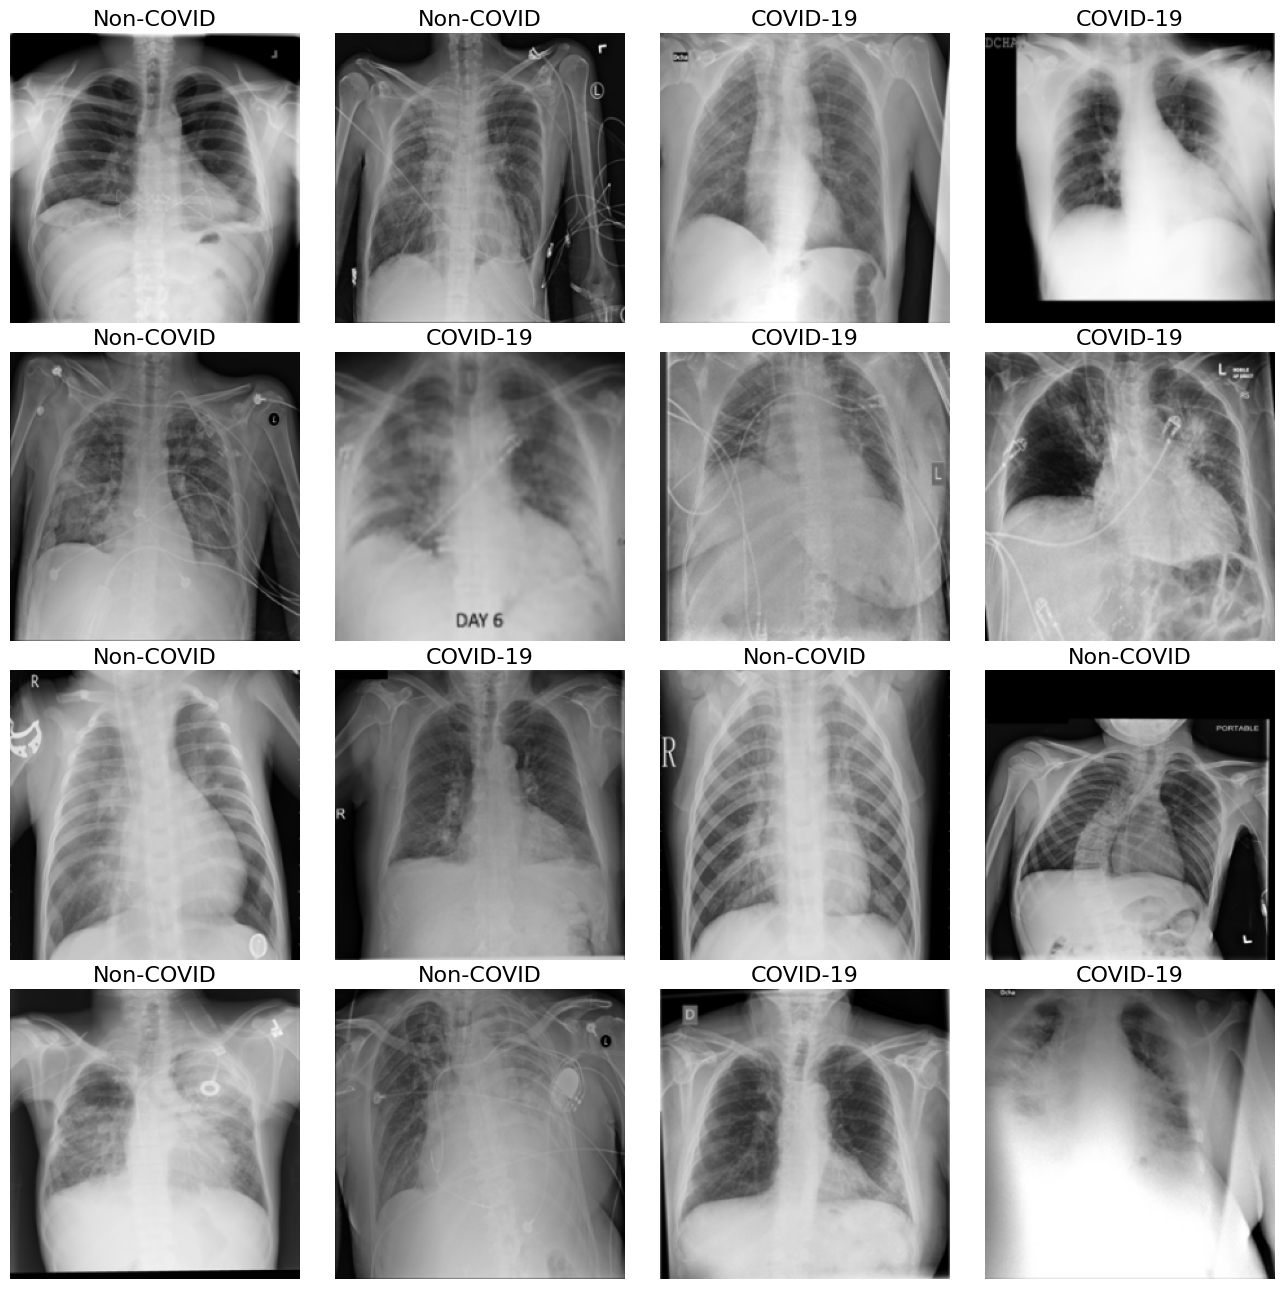

In [ ]:
# run this cell again for another randomized set of training images
display_batch(next(train_batch))

In [ ]:
print("Training data shapes:")
for image, label in get_train_dataset().take(1):
    print(image.numpy().shape, label.numpy().shape)

print("Validation data shapes:")
for image, label in get_train_dataset().take(1):
    print(image.numpy().shape, label.numpy().shape)

print("Test data shapes:")
for image, label in get_test_dataset().take(1):
    print(image.numpy().shape, label.numpy().shape)

Training data shapes:
(16, 224, 224, 3) (16, 3)
Validation data shapes:
(16, 224, 224, 3) (16, 3)
Test data shapes:
(16, 224, 224, 3) (16, 3)


Create a Model

In [ ]:
#checkpoint = tf.keras.callbacks.ModelCheckpoint(
#    'best_xception.h5',
#    monitor='val_loss',
#    verbose=1,
#    save_best_only=True,
#    mode='min'
#)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'anthonymlmodel.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-7,
)

In [ ]:
#with strategy.scope():
#    baseModel = tf.keras.applications.Xception(
#        include_top=False,
#        weights='imagenet',
#        input_shape=(224, 224, 3),
#    )
#
#    model = tf.keras.Sequential([
#        baseModel,
#        tf.keras.layers.GlobalAveragePooling2D(),
#        tf.keras.layers.Dense(NUM_CLASS, activation='softmax')
#    ])

#    model.compile(
#        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
#        loss='categorical_crossentropy',
#        metrics=['accuracy']
#    )

In [ ]:
with strategy.scope():
    baseModel = tf.keras.applications.EfficientNetB7(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
    )

 #   model = tf.keras.Sequential([
 #       baseModel,
 #       tf.keras.layers.GlobalAveragePooling2D(),
 #       tf.keras.layers.Dense(NUM_CLASS, activation='softmax')
 #   ])

    model = tf.keras.Sequential([
         baseModel,
         tf.keras.layers.GlobalAveragePooling2D(),
         tf.keras.layers.Dropout(0.5),
             tf.keras.layers.Flatten(),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.Dense(32,kernel_initializer='he_uniform'),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.Activation('relu'),
             tf.keras.layers.Dropout(0.5),
             tf.keras.layers.Dense(32,kernel_initializer='he_uniform'),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.Activation('relu'),
             tf.keras.layers.Dropout(0.5),
             tf.keras.layers.Dense(32,kernel_initializer='he_uniform'),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.Activation('relu'),
             tf.keras.layers.Dense(NUM_CLASS, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 global_average_pooling2d_1   (None, 2560)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2560)              0         
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 2560)             10240     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)               

Train The Model

In [ ]:
history = model.fit(
    get_train_dataset(augment=True),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=get_validation_dataset(),
    validation_steps=VALIDATION_STEPS,
    callbacks=[checkpoint, reduce_lr]
)

model.save()

Evaluate The Model

In [ ]:
model = tf.keras.models.load_model('anthonymlmodel.h5')

In [ ]:
val_dataset = get_validation_dataset(ordered=True)
results = model.evaluate(
    val_dataset, batch_size=BATCH_SIZE, steps=VALIDATION_STEPS)
print('Test loss: {:4f}'.format(results[0]))
print('Test accuracy: {:4f}'.format(results[1]))

In [ ]:
images_ds = val_dataset.map(lambda image, label: image)
labels_ds = val_dataset.map(lambda image, label: label).unbatch()
correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()

pred = model.predict(val_dataset, steps=VALIDATION_STEPS)

y_true = np.argmax(correct_labels, axis=-1)
y_pred = np.argmax(pred, axis=-1)

print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
display_confusion_matrix(cm=cm, classes=CLASSES, title='Confusion Matrix')

Test The Model

In [ ]:
dataset = get_test_dataset()
dataset = dataset.unbatch().batch(300)
batch = iter(dataset)

In [ ]:
# run this cell again for next set of images
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch((images, labels), predictions)